In [1]:
import ete3
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
from scipy.stats import spearmanr, linregress
import itertools
from Bio import SeqIO, SearchIO, AlignIO, Align, Alphabet
import re
import multiprocessing
from copy import deepcopy

class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

os.chdir('/work/site_rate/hug_et_al')
ncbi        = ete3.NCBITaxa()
num_threads = 10

<h3 align="center">Precomputed data</h3>

yeah\!


In [2]:
tree = ete3.Tree('ribosomal_concat.fasta.treefile', format=1)

In [6]:
bacteria     = []
archaea      = []
eukarya      = []
for leaf in tree.get_leaf_names():
    if leaf.startswith('Bacteria'):
        bacteria.append(leaf)
    elif leaf.startswith('Archaea'):
        archaea.append(leaf)
    elif leaf.startswith('Eukaryota'):
        eukarya.append(leaf)

In [7]:
tree.set_outgroup(eukarya[0])
bacteria_ancestor = tree.get_common_ancestor(bacteria)
tree.set_outgroup(bacteria_ancestor)

os.chdir('/work/site_rate/hug_et_al/categories/')
tree.write(outfile='species.tre', dist_formatter='%.20f', format=5)

In [ ]:
number_of_rate_categories  = 12

category_support_df = pd.DataFrame(columns='category topology_id support branch_length'.split())
for category in range(1,number_of_rate_categories+1):
    print category
    
    tmp_tree = ete3.Tree('%i.treefile' %category)

    tmp_tree.set_outgroup(eukarya[0])
    outgroup = tmp_tree.get_common_ancestor(bacteria)
    tmp_tree.set_outgroup(outgroup)

    tmp_supports       = []
    tmp_topology_ids   = []
    tmp_branch_lengths = []
    for node in tmp_tree.traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_supports.append(node.support)
            tmp_topology_ids.append(node.get_topology_id())
            tmp_branch_lengths.append(node.dist)

    tmp_df = pd.DataFrame(
                zip([category]*len(tmp_supports),
                    tmp_topology_ids,
                    tmp_supports,
                    tmp_branch_lengths),
                columns='category topology_id support branch_length'.split())
    category_support_df = category_support_df.append(tmp_df)

for node in tree.traverse():
    if not node.is_leaf() and not node.is_root():
        tmp_topology_id = node.get_topology_id()
        category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

category_support_df.to_csv('category_supports.tab', sep='\t')

In [4]:
category_support_df = pd.read_table('categories/category_supports.tab', index_col=0)

In [5]:
branch_lengths = category_support_df.loc[
    category_support_df.category == 1,
    'branch_length'.split()].values.squeeze()

branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
binning            = np.digitize(category_support_df['branch_length'].values.squeeze(), branch_length_bins)
bin_names          = {}

for bin in set(binning):
    min_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
    max_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
    bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

category_support_df['branch_length_bin'] = [bin_names[bin] for bin in binning]

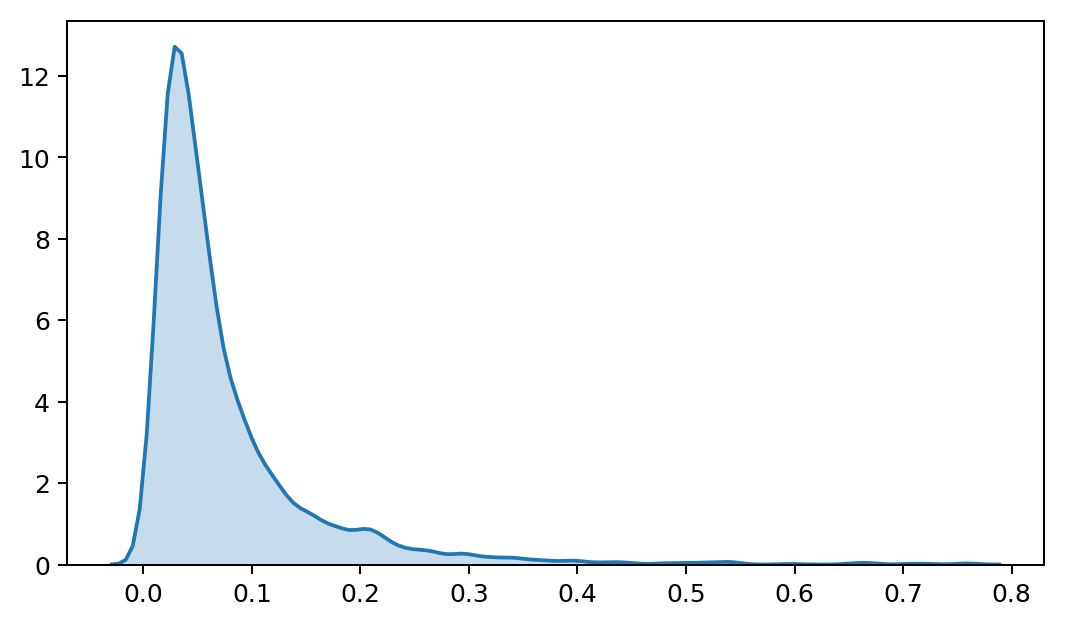

In [7]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(branch_lengths, shade=True, ax=ax)
fig.set_size_inches(7,4)

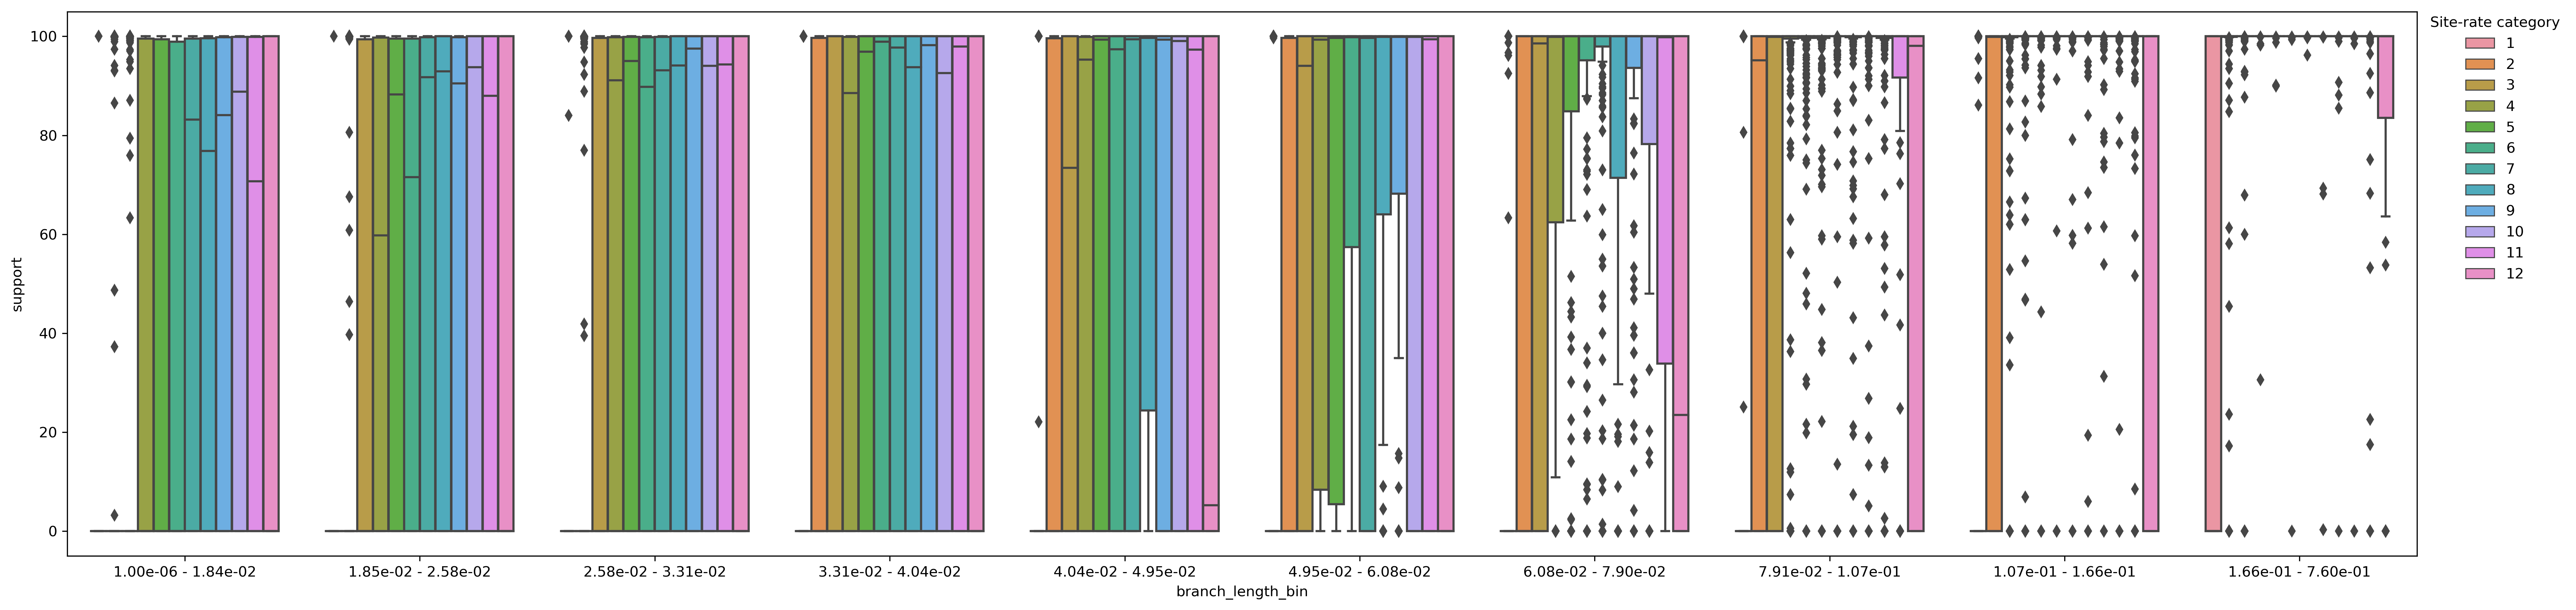

In [107]:
fig, ax = plt.subplots(dpi=300)
sns.boxplot(x='branch_length_bin', y='support', hue='category', order=bin_names.values(), data=category_support_df, ax=ax)
fig.set_size_inches(25,6)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
#fig.savefig('support_binned_by_branch_length-decile_binned.pdf', dpi=300)
#plt.close()